In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
!ls ../data/

enregistrement_AM_2017-10-23_100057.asc
enregistrement_AM_2017-10-23_100057.edf
enregistrement_AM_2017-10-23_100057.pkl
enregistrement_BMC_2017-09-26_095637.asc
enregistrement_BMC_2017-09-26_095637.EDF
enregistrement_BMC_2017-09-26_095637.pkl
enregistrement_CS_2017-10-03_134421.asc
enregistrement_CS_2017-10-03_134421.edf
enregistrement_CS_2017-10-03_134421.pkl
enregistrement_DC_2017-09-27_161040.asc
enregistrement_DC_2017-09-27_161040.edf
enregistrement_DC_2017-09-27_161040.pkl
enregistrement_FM_2017-10-03_143803.asc
enregistrement_FM_2017-10-03_143803.EDF
enregistrement_FM_2017-10-03_143803.pkl
enregistrement_IP_2017-09-28_115250.asc
enregistrement_IP_2017-09-28_115250.edf
enregistrement_IP_2017-09-28_115250.pkl
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
enregistrement_OP_2017-10-26_121823.asc
enregistrement_OP_2017-10-26_121823.edf
enregistrement_OP_2017-10-26_1218

In [3]:
timeStr = '2017-10-26_121823'
observer = 'OP'
mode = 'enregistrement'

In [7]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [8]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [9]:
def exponentiel (x, tau, maxi, start_anti, v_anti, latence, bino, start_dec, tau_dec) :
    '''
    tau -- courbe
    maxi -- maximum
    latence -- tps où commence le mvt
    bino -- binomial
    
    start_anti = debut de l'anticipation
    v_anti =  vitesse de l'anticipation
    ''' 
    v_anti = v_anti/1000 # pour passer de sec à ms
    #v_dec = v_dec/1000
    time = np.arange(len(x))
    vitesse = []
    
    time_dec = []
    tutu = []
    start_dec = int(start_dec)

    for t in range(len(time)):
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
                x = (time[t]-start_anti)*v_anti
            else :
                if latence+latence*(tau/30) > start_dec :
                    vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
                else :

                    if time[t] < start_dec :
                        vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
                    else :
                        vitesse.append(-(bino*2-1)*(np.exp(1/tau_dec*(time[t]-start_dec)))+(chouchou+(bino*2-1)))
        else :

            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append((time[t]-start_anti)*v_anti)
                    x = (time[t]-start_anti)*v_anti
                else :
                    if latence+len(time)*(tau/300) > start_dec :
                        vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
                    else :
                        
                        if time[t] <= start_dec :
                            vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
                        else :
                            vitesse.append(-(bino*2-1)*(np.exp(1/tau_dec*(time[t]-start_dec)))+(vitesse[start_dec]+(bino*2-1)))

    return vitesse

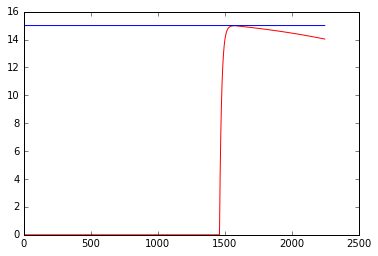

In [10]:
plt.plot(exponentiel(np.arange(2247), tau=15, maxi=15., start_anti=1360-100, latence=1360+100, v_anti=0, bino=1, start_dec=int((1360+100)+(2247*(15/300)))+1, tau_dec=1000), c='r')
plt.plot(np.ones(2247)*15)

ValueError: operands could not be broadcast together with shapes (2247,) (500,) 

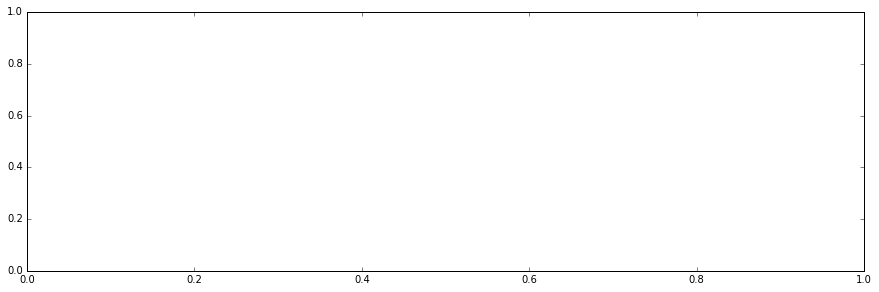

In [10]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
block = 0
trial = 64

trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

##################################################
# SUPPRESSION DES SACCADES
##################################################
gradient_deg_NAN = gradient_deg

for s in range(len(saccades)) :
    if saccades[s][1]-trackertime_0+15 <= (len(trackertime)) :
        for x_data in np.arange((saccades[s][0]-trackertime_0-5), (saccades[s][1]-trackertime_0+15)) :
            gradient_deg_NAN[x_data] = np.nan
    else :
        for x_data in np.arange((saccades[s][0]-trackertime_0-5), (len(trackertime))) :
            gradient_deg_NAN[x_data] = np.nan

stop_latence = []    
for s in range(len(saccades)) :
    if (saccades[s][0]-trackertime_0) >= (TargetOn-trackertime_0+100) :
        stop_latence.append((saccades[s][0]-trackertime_0))
if stop_latence==[] :
    stop_latence.append(len(trackertime))
##################################################

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start

# FIT
model = Model(exponentiel)
bino=p[trial, block, 0]
params = Parameters()

params.add('tau', value=15., min=13., max=150.)#, vary=False)
params.add('maxi', value=15., min=1., max=30.)#, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0+50, max=stop_latence[0])
params.add('start_anti', value=TargetOn-trackertime_0-100, min=StimulusOf-trackertime_0, max=TargetOn-trackertime_0-50)
params.add('v_anti', value=0., min=-40., max=40.)
params.add('bino', value=bino, min=0, max=1, vary=False)
params.add('start_dec', value=TargetOn-trackertime_0+250, min=TargetOn-trackertime_0+100, max=len(trackertime))
params.add('tau_dec', value=300., min=0.1, max=300.)


#result_deg = model.fit(new_gradient_deg, params, x=new_time)
result_deg = model.fit(gradient_deg_NAN[:500], params, x=trackertime[, fit_kws={'nan_policy': 'omit'})

debut  = TargetOn - trackertime_0 # TargetOn - temps_0

axs.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])

axs.plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
axs.plot(trackertime_s[:500], result_deg.init_fit, 'r--', linewidth=2)
axs.plot(trackertime_s[:500], result_deg.best_fit, color='r', linewidth=2)
axs.plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*15, color='k', linewidth=0.2, alpha=0.2)
axs.plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*10, color='k', linewidth=0.2, alpha=0.2)


axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
for s in range(len(saccades)) :
    axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

start_anti = result_deg.values['start_anti']-debut
v_anti = result_deg.values['v_anti']
latence = result_deg.values['latence']-debut
tau = result_deg.values['tau']
maxi = result_deg.values['maxi']
start_dec = result_deg.values['start_dec']-debut
tau_dec = result_deg.values['tau_dec']

if start_anti > latence :
    start_anti = np.nan

if latence+len(trackertime)*(tau/300) > start_dec :
    start_dec = np.nan
    tau_dec = np.nan

axs.bar(latence, 80, bottom=-40, color='r', width=6, linewidth=0)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 31, "FIXATION", color='k', fontsize=16, ha='center', va='bottom')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='r', fontsize=16, ha='center', va='bottom')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 31, "POURSUITE", color='k', fontsize=16, ha='center', va='bottom')
axs.text(latence+25, -35, "Latence", color='r', fontsize=14)#,  weight='bold')
axs.text(StimulusOn_s+15, 18, "start_anti: %s \nv_anti: %s"%(start_anti, v_anti), color='k', fontsize=14, va='bottom')
axs.text(StimulusOn_s+15, -18, "latence: %s \ntau: %s \nmaxi: %s"%(latence, tau, maxi), color='k', fontsize=14, va='top')
axs.text(StimulusOn_s+500, -18, "start_dec: %s \ntau_dec: %s"%(start_dec, tau_dec), color='k', fontsize=14, va='top')


axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)
plt.show()
print(result_deg.fit_report())

In [ ]:
liste_start_anti = []
liste_liste_v_anti = []
liste_latence = []
liste_tau = []
liste_maxi = []
liste_mean = []
liste_start_dec = []
liste_tau_dec = []

for block in range(N_blocks) :
    fig_width= 12
    fig, axs = plt.subplots(N_trials, 1, figsize=(fig_width, (fig_width*(N_trials/2))/1.6180))

    block_start_anti = []
    block_liste_v_anti = []
    block_latence = []
    block_tau = []
    block_maxi = []
    block_mean = []
    block_start_dec = []
    block_tau_dec = []
    
    for trial in range(N_trials) :

        print(block, trial)
        
        trial_data = trial + N_trials*block
        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']

        trackertime_0 = data[trial_data]['trackertime'][0]

        gradient_x = np.gradient(data_x)
        gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

        ##################################################
        # SUPPRESSION DES SACCADES
        ##################################################
        gradient_deg_NAN = gradient_deg

        for s in range(len(saccades)) :
            if saccades[s][1]-trackertime_0+15 <= (len(trackertime)) :
                for x_data in np.arange((saccades[s][0]-trackertime_0-5), (saccades[s][1]-trackertime_0+15)) :
                    gradient_deg_NAN[x_data] = np.nan
            else :
                for x_data in np.arange((saccades[s][0]-trackertime_0-5), (len(trackertime))) :
                    gradient_deg_NAN[x_data] = np.nan
            
        stop_latence = []    
        for s in range(len(saccades)) :
            if (saccades[s][0]-trackertime_0) >= (TargetOn-trackertime_0+100) :
                stop_latence.append((saccades[s][0]-trackertime_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        ##################################################
        
        start = TargetOn
        
        StimulusOn_s = StimulusOn - start
        StimulusOf_s = StimulusOf - start
        TargetOn_s = TargetOn - start
        TargetOff_s = TargetOff - start
        trackertime_s = trackertime - start
        
        ##################################################
        # FIT
        ##################################################
        model = Model(exponentiel)
        bino=p[trial, block, 0]
        params = Parameters()
        params.add('tau', value=15., min=13., max=150.)#, vary=False)
        params.add('maxi', value=15., min=1., max=30.)#, vary=False)
        params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0+50, max=stop_latence[0])
        params.add('start_anti', value=TargetOn-trackertime_0-100, min=StimulusOf-trackertime_0, max=TargetOn-trackertime_0-50)
        params.add('v_anti', value=0., min=-40., max=40.)
        params.add('bino', value=bino, min=0, max=1, vary=False)
        params.add('start_dec', value=TargetOn-trackertime_0+300, min=TargetOn-trackertime_0+100, max=TargetOff-trackertime_0)
        params.add('tau_dec', value=30., min=10., max=500.)

        result_deg = model.fit(gradient_deg_NAN, params, x=trackertime, fit_kws={'nan_policy': 'omit'})
        ##################################################

        axs[trial].cla() # pour remettre ax figure a zero
        axs[trial].axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])

        axs[trial].plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
        axs[trial].plot(trackertime_s, result_deg.init_fit, 'r--', linewidth=2)
        axs[trial].plot(trackertime_s, result_deg.best_fit, color='r', linewidth=2)
        axs[trial].plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*(15), color='k', linewidth=0.2, alpha=0.2)
        axs[trial].plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*(10), color='k', linewidth=0.2, alpha=0.2)
        axs[trial].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
        axs[trial].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
        axs[trial].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
        for s in range(len(saccades)) :
            axs[trial].axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

        debut  = TargetOn - trackertime_0 # TargetOn - temps_0
        
        start_anti = result_deg.values['start_anti']-debut
        v_anti = result_deg.values['v_anti']
        latence = result_deg.values['latence']-debut
        tau = result_deg.values['tau']
        maxi = result_deg.values['maxi']
        start_dec = result_deg.values['start_dec']-debut
        tau_dec = result_deg.values['tau_dec']
        
        if start_anti > latence :
            start_anti = np.nan

        if latence+len(trackertime)*(tau/300) > start_dec :
            start_dec = np.nan
            tau_dec = np.nan
            
        elif start_dec == TargetOff-trackertime_0 :
            start_dec = np.nan
            tau_dec = np.nan            
        
        
        block_start_anti.append(start_anti)
        block_liste_v_anti.append(v_anti)
        block_latence.append(latence)
        block_tau.append(tau)
        block_maxi.append(maxi)
        block_mean.append(np.nanmean(gradient_deg_NAN[debut-50:debut+50]))
        block_start_dec.append(start_dec)
        block_tau_dec.append(tau_dec)

        axs[trial].bar(latence, 80, bottom=-40, color='r', width=6, linewidth=0)
        
        if trial==0 :
            axs[trial].text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 31, "FIXATION", color='k', fontsize=16, ha='center', va='bottom')
            axs[trial].text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='r', fontsize=16, ha='center', va='bottom')
            axs[trial].text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 31, "POURSUITE", color='k', fontsize=16, ha='center', va='bottom')
            axs[trial].text(latence+25, -35, "Latence"%(latence), color='r', fontsize=14)#,  weight='bold')
        #axs[trial].text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=15)
        axs[trial].text(StimulusOn_s+15, 18, "start_anti: %s \nv_anti: %s"%(start_anti, v_anti), color='k', fontsize=14, va='bottom')
        axs[trial].text(StimulusOn_s+15, -18, "latence: %s \ntau: %s \nmaxi: %s"%(latence, tau, maxi), color='k', fontsize=14, va='top')
        axs[trial].text(StimulusOn_s+500, -18, "start_dec: %s \ntau_dec: %s"%(start_dec, tau_dec), color='k', fontsize=14, va='top')

        axs[trial].set_xlabel('Time (ms)', fontsize=9)
        axs[trial].set_ylabel(trial+1, fontsize=9)

    liste_start_anti.append(block_start_anti)
    liste_liste_v_anti.append(block_liste_v_anti)
    liste_latence.append(block_latence)
    liste_tau.append(block_tau)
    liste_maxi.append(block_maxi)
    liste_mean.append(block_mean)
    liste_start_dec.append(block_start_dec)
    liste_tau_dec.append(block_tau_dec)

    plt.tight_layout() # pour supprimer les marge trop grande
    plt.subplots_adjust(hspace=0) # pour enlever espace entre les figures

    plt.savefig('figures/Test_Fit_dec_%s_%s_block-%s.pdf'%(observer, timeStr, block+1))

plt.close()

param = {}
param['observer'] = observer
param['start_anti'] = liste_start_anti
param['v_anti'] = liste_liste_v_anti
param['latence'] = liste_latence
param['tau'] = liste_tau
param['maxi'] = liste_maxi
param['moyenne'] = liste_mean
param['start_dec'] = liste_start_dec
param['tau_dec'] = liste_tau_dec

file = os.path.join('parametre', observer + '_param_Fit_Test.pkl')
with open(file, 'wb') as fichier:
    f = pickle.Pickler(fichier)
    f.dump(param)

print('FIN !!!')

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85


/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice


0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184
0 185
0 186
0 187
0 188
0 189
0 190
0 191
0 192
0 193
0 194
0 195
0 196
0 197
0 198
0 199
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67


KeyboardInterrupt: 